## Image Preprocessing Pipeline

#### 1. Numpy

Found 2 image(s)

Processed 2 image(s)
Total Execution Time: 2.1322 seconds
Estimated Memory Bandwidth: 0.026 GB/s
GPU Memory Used: 455.88 MB
GPU Memory Total: 15360.00 MB


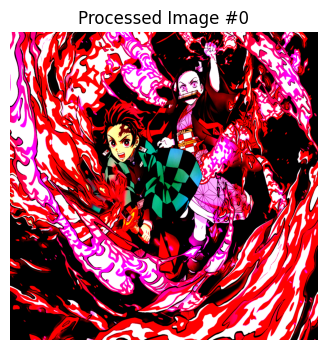

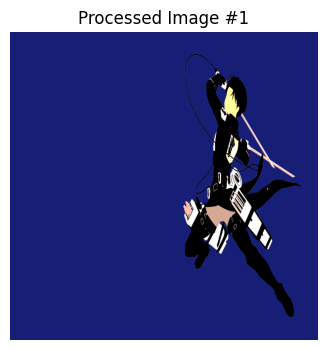

In [1]:
import os
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from numba import cuda, float32
import pynvml

def print_gpu_memory_usage():
    pynvml.nvmlInit()
    h = pynvml.nvmlDeviceGetHandleByIndex(0)
    mem = pynvml.nvmlDeviceGetMemoryInfo(h)
    print(f"GPU Memory Used: {mem.used / 1024**2:.2f} MB")
    print(f"GPU Memory Total: {mem.total / 1024**2:.2f} MB")

@cuda.jit
def normalize_kernel(src, out):
    idx = cuda.grid(1)
    if idx < src.size:
        out[idx] = src[idx] / 255.0

@cuda.jit
def standardize_kernel(src, mean, std, out):
    idx = cuda.grid(1)
    if idx < src.size:
        out[idx] = (src[idx] - mean[0]) / (std[0] + 1e-8)

def preprocess_image_cuda(path, target_size=(1080, 1080), to_gray=False):
    img = Image.open(path).convert('L' if to_gray else 'RGB')
    img = img.resize(target_size, Image.Resampling.LANCZOS)
    img_np = np.asarray(img, dtype=np.float32).ravel()

    d_img = cuda.to_device(img_np)
    d_norm = cuda.device_array_like(d_img)

    threads = 256
    blocks = (img_np.size + threads - 1) // threads
    normalize_kernel[blocks, threads](d_img, d_norm)
    cuda.synchronize()

    norm = d_norm.copy_to_host()
    mean = np.array([np.mean(norm)], dtype=np.float32)
    std = np.array([np.std(norm)], dtype=np.float32)

    d_out = cuda.device_array_like(d_img)
    d_mean = cuda.to_device(mean)
    d_std = cuda.to_device(std)

    standardize_kernel[blocks, threads](d_norm, d_mean, d_std, d_out)
    cuda.synchronize()

    result = d_out.copy_to_host()
    channels = 1 if to_gray else 3
    return result.reshape((target_size[1], target_size[0], channels)) if not to_gray else result.reshape(target_size[::-1])

def run_pipeline_on_folder_gpu(folder_path, to_gray=False):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not image_files:
        print("No image files found.")
        return

    print(f"Found {len(image_files)} image(s)")
    
    total_bytes = 0
    processed = []

    start = time.time()
    for f in image_files:
        img = preprocess_image_cuda(os.path.join(folder_path, f), to_gray=to_gray)
        processed.append(img)
        total_bytes += img.size * img.itemsize * 2  
    cuda.synchronize()
    end = time.time()

    elapsed = end - start
    bandwidth = total_bytes / elapsed / 1e9  # GB/s

    print(f"\nProcessed {len(processed)} image(s)")
    print(f"Total Execution Time: {elapsed:.4f} seconds")
    print(f"Estimated Memory Bandwidth: {bandwidth:.3f} GB/s")
    print_gpu_memory_usage()

    for i, img in enumerate(processed[:2]):
        plt.figure(figsize=(4, 4))
        plt.imshow(img, cmap='gray' if to_gray else None)
        plt.axis('off')
        plt.title(f"Processed Image #{i}")
        plt.show()

# run_pipeline_on_folder_gpu("/images", to_gray=False)    #if running on local desktop
run_pipeline_on_folder_gpu("/kaggle/input/images")      #if running on kaggle

#### 3. C++

In [2]:
import cupy
print("CuPy version:", cupy.__version__)
print("CUDA version:", cupy.cuda.runtime.runtimeGetVersion() // 1000)


CuPy version: 13.4.1
CUDA version: 12


In [3]:
!pip install opencv-python-headless cupy-cuda11x numba
!pip install opencv-python-headless cupy-cuda11x numba matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 MB 16.9 MB/s eta 0:00:00:00:010:01


Found 2 image(s)
✅ Saved: processed_0.png


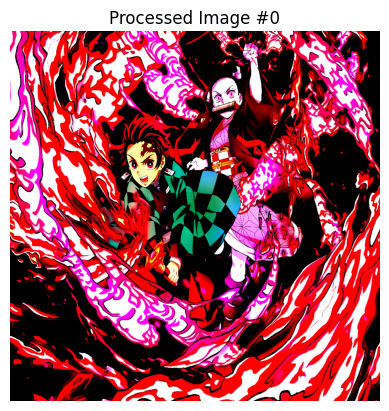

libpng warning: iCCP: known incorrect sRGB profile


✅ Saved: processed_1.png


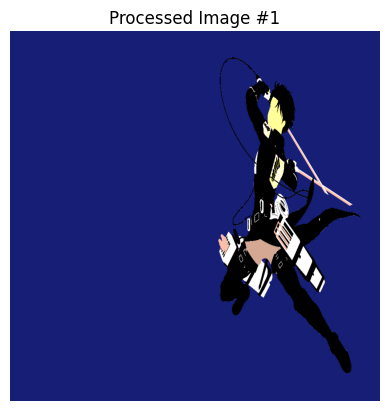

⏱️ Total Execution Time: 0.89s
🚀 Estimated Memory Bandwidth: 0.063 GB/s
📊 GPU Memory Used: 14.00 MB


In [5]:
import cv2
import numpy as np
import cupy as cp
import numba
from numba import cuda
import time
from glob import glob
import matplotlib.pyplot as plt

@cuda.jit
def standardize_kernel(img, mean_val, std_val, out):
    i, j, c = cuda.grid(3)
    if i < img.shape[0] and j < img.shape[1] and c < img.shape[2]:
        out[i, j, c] = (img[i, j, c] - mean_val[0]) / (std_val[0] + 1e-8)

def preprocess_with_cuda(image_path, target_size=(1080, 1080), to_gray=False):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        print(f"Failed to load {image_path}")
        return None

    if to_gray and img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    elif not to_gray and img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    img = cv2.resize(img, target_size, interpolation=cv2.INTER_LANCZOS4)
    img = img.astype(np.float32) / 255.0

    d_img = cp.asarray(img)
    mean_val = cp.mean(d_img)
    std_val = cp.std(d_img)

    out = (d_img - mean_val) / (std_val + 1e-8)

    return out


def display_image(img, title="Processed Image"):
    if img.ndim == 3 and img.shape[2] == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

def run_pipeline(folder_path):
    paths = glob(f"{folder_path}/*.jpg") + glob(f"{folder_path}/*.png")
    print(f"Found {len(paths)} image(s)")

    total_bytes = 0
    start = time.time()

    for i, path in enumerate(paths[:2]):
        processed = preprocess_with_cuda(path)
        if processed is not None:
            total_bytes += processed.size * processed.dtype.itemsize * 2  
            img_out = cp.clip(processed * 255, 0, 255).astype(cp.uint8).get()
            save_path = f"processed_{i}.png"
            cv2.imwrite(save_path, img_out)
            print(f"✅ Saved: {save_path}")
            display_image(img_out, f"Processed Image #{i}")

    end = time.time()
    elapsed = end - start
    bandwidth = total_bytes / elapsed / 1e9  

    print(f"⏱️ Total Execution Time: {elapsed:.2f}s")
    print(f"🚀 Estimated Memory Bandwidth: {bandwidth:.3f} GB/s")
    print(f"📊 GPU Memory Used: {cp.get_default_memory_pool().used_bytes() / 1e6:.2f} MB")

# run_pipeline("/images")                 #if running on local desktop
run_pipeline("/kaggle/input/images")    #if running on kaggle